In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

# Project 2
## Candidates 15908 & 15907

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from astropy.modeling.models import BlackBody
from astropy.modeling.blackbody import blackbody_lambda
from scipy.special import wofz

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

### Exercise 1
At the end of the 19th century, german phycisist Max Planck derived a law describing radiation emitted by a black body in thermal equilibrium. The law determines the intensity radiated from the black body at a certain temperature. It can be written in terms of wavelength as
\begin{equation} 
   B_\lambda(T) = \frac{2hc^2}{\lambda^5} 
                  \frac{1}{\mathrm{e}^{hc/\lambda kT}-1}\,.
   \label{eq:BB}
\end{equation}

We can plot the function over wavelength at a range of different temperatures by making use of the python package $\texttt{astropy}$'s funcationalities.

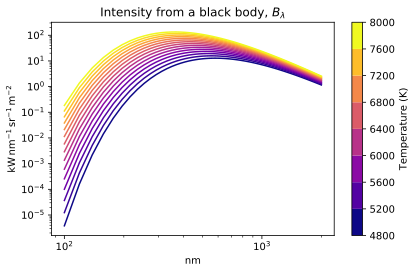

In [3]:
from cycler import cycler
from matplotlib import cm #colormap

i_units = "kW m-2 sr-1 nm-1" # defining more practical SI units

wave = np.linspace(100,2000,100) * units.nm # wavelength array
temp = np.linspace(5000,8000,15) * units.K # Temperature array
radiation = BlackBody(temp, scale=1.*units.Unit(i_units))(wave[:,np.newaxis]) # Calculating intensity curve

fig, ax = plt.subplots()
custom_cycler = cycler('color', cm.plasma(np.linspace(0,1,len(temp)))) #going to go through the whole cm
ax.set_prop_cycle(custom_cycler) #change default colours of plots
ax.set_title(r'Intensity from a black body, $B_\lambda$')
bar = plt.contourf(radiation/radiation*temp, colors = cm.plasma(np.linspace(0,1,8)))
fig.colorbar(bar).set_label("Temperature (K)")
ax.loglog(wave, radiation.to('kW m-2 nm-1 sr-1')) # Plotting intensity vs wavlength for each temperature
plt.tight_layout(h_pad=1);

Here, we see the Planck function plotted as a function of wavelengths over a range of temperatures between 5000 and 8000 K. We see that the total intensity and peaks are dependent of temperature. A higher temperature gives more intensity and shifts the intensity peak to smaller wavelengths. We see the different curves tend toward each other for large $\lambda$. This comes from the behaviour of the exponential term in Planck's law for large wavelengths. In this limit the exponential term can be approximated to the Rayleigh-Jeans law,
\begin{equation} 
    B_\lambda(T) = \frac{2c k_\text{B}T}{\lambda^4} \,.
    \label{eq:JR}
\end{equation}
This law only has a linear dependence of temperature, while being suppressed by the $1/\lambda^4$ term. In the logarithmic plot, the intensity should therefore decline linearly like $-4\lambda$. For small wavelengths, the temperature exponentially suppresses the radiation from the black body.

When we observe radiation from a medium, we have to account for background-radiation passing through the medium, and radiation coming from the medium itself. If we assume the medium to be an isothermal black body, the total emergent intensity is 
\begin{equation} 
   I_\lambda = I_\lambda(0) \mathrm{e}^{-\tau} 
        + B_\lambda \, \left( 1 - \mathrm{e}^{-\tau} \right)\,,
   \label{eq:ISO}
\end{equation}
where $I_\lambda(0)$ is the intensity of a beam radiating into the medium from the background.
We can watch how the isothermal black body looks like with different intensity beams coming from the background by plotting the intensity through the medium for different $I_\lambda(0)$. Implementing a function for equation \eqref{eq:ISO}, we plot the intensity against the optical depth of the medium.

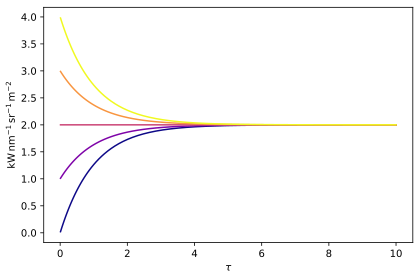

In [4]:
def isothermal_intensity(I0, tau, b_lambda):
    # Function to calculate the intensity in the layer as a function of optical depth #
    return I0*np.exp(-tau) + b_lambda*(1 - np.exp(-tau))

tau = np.logspace(-2, 1, 100) # Optical depth array
i0 = np.arange(5) # incoming beam intensity array
b_lambda = 2 # Blackbody intensity of medium

I_slab = isothermal_intensity(i0, tau[:,np.newaxis], b_lambda)*units.Unit(i_units) # Intensity matrix. All intensity function values for optical depth, and all starting intensities

fig, ax = plt.subplots()
custom_cycler = cycler('color', cm.plasma(np.linspace(0,1,len(i0)))) #going to go through the whole cm
ax.set_prop_cycle(custom_cycler) #change default colours of plots
ax.set_xlabel(r'$\tau$')
ax.plot(tau, I_slab) # Plotting all intensity functions vs optical depth
plt.tight_layout(h_pad=1);

We can see that the emergent intensity reaches the source function $B_\lambda$ of the black body when it is optically thick. To better see the different regimes of optical depth, we logarithmically visualize the intensity.

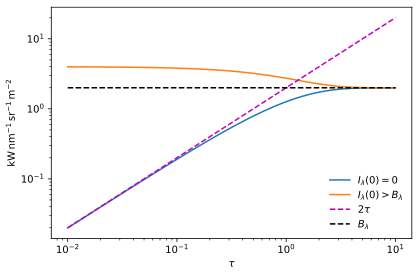

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$\tau$')
ax.loglog(tau, I_slab[:,0], tau, I_slab[:, -1]) # Plotting intensity vs optical depth for only two values, I_0 larger and smaller than source function
ax.loglog(tau, 2*tau, ls = "--", color='m') # Linear dependance helpline
ax.loglog(tau, b_lambda*np.ones(len(tau)), ls = "--", color='k') # Boltzmann distribution for medium at specific wavelength
plt.legend([r"$I_\lambda(0) = 0$", r"$I_\lambda(0) > B_\lambda$", r"$2\tau$", r"$B_\lambda$"])
plt.tight_layout(h_pad=1);

In this plot, we see two different regimes for $\tau$. First we will study $\tau \ll 1$. For initial beam intensity $I_\lambda(0) = 0$, we see a linear incline in the logplot. In this regime, the intensity increases linearly like $\tau$. When $I_\lambda(0) > B_\lambda$, the incoming intensity is almost constant. Therefore it is almost no extinction. A layer with $\tau \ll 1$ is called optically thin because almost all radiation passes through it. Therefore, one could call it radiatively thin.

In the regime $\tau \gg 1$, we see that the emergent intensity of the black body is equal to its source function. No radiation passes through the medium, and all observed radiaton comes from the black body. Therefore we call layers with $\tau \gg 1$ optically thick. We see that the different curves converge quickly towards $B_\lambda$, and are practically constant and independent of $\tau$. In physical terms, this means that all incoming radiation is absorbed by the medium after some treshold value for $\tau \gg 1$.

### Exercise 2

To further look at the result of a black body radiating through a medium we can use a Schuster-Schwarzchild model to approximate a lineprofile that results from a beam through a medium consisting of one element. The resulting intensity for a specific wavelength is then given by the intensity of an optically thick medium plus the intensity of an optically thin medium.
\begin{equation}
I_{\lambda} = B_{\lambda} e^{- \tau_0} + B_{\lambda} (1 - e^{- \tau})\,.
\end{equation}
This equation is the same as the one earlier used for the isothermal layer, except that the initial intensity is chosen using a Boltzmann distribution. If we want to plot this intensity over a distribution of wavelengths to get a spectral line profile, we need an expression for the optical depth. We can find this by choosing an initial value at the surface of the black body and using the voigt function to calculate a new optical depth inside the medium. We choose to use unitless wavelength $u$ normalised by the doppler wavelength and get an expression for the optical depth
\begin{equation}
    \tau = \tau_0 V(a, u)\,,
\end{equation}
where V is the voigt function given by the integral
\begin{equation}
    V(a, u) \equiv \frac{1}{\Delta \lambda_\mathrm{D} \sqrt{\pi}} \,
                 \frac{a}{\pi} \int_{-\infty}^{+\infty} \,
            \frac{e^{-y^2}}{(u - y)^2 + a^2} \mathrm{d} y\,,
\end{equation}
and a is the dampening parameter which simulates broadening in the spectral line. Usually this has a value between 0.01 and 0.5. We choose $\texttt{scipy.special}$'s wolfz function to calculate this integral for us, and get the following profiles for different temperatures, initial optical depths and dampenings. In the red line, our model uses a surface temperature of 8770 Kelvin and a layer temperature of 7000 Kelvin. It also has a dampening of $a = 0.01$ and an initial optical depth of $\tau_0 = 10^2$.

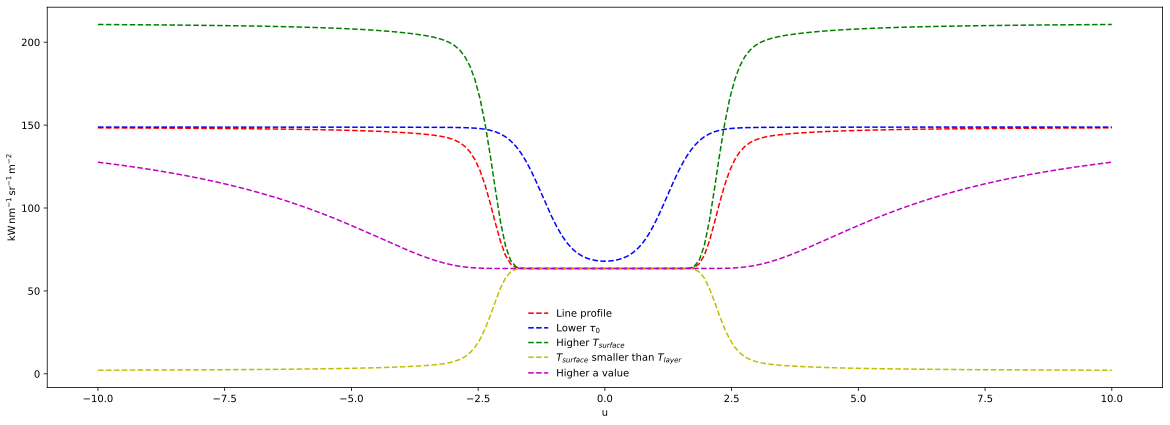

In [6]:
def voigt(damping, u):
    """
    Calculates the Voigt function.
    """
    
    z = (u + 1j * damping)
    return wofz(z).real

temp_surface = 8770 * units.K # Black body surface temperature
temp_layer = 7000 * units.K # Layer temperature
tau0 = 10 ** 2 # Initial optical depth at surface of black body
lam_0 = 500 * units.nm # Wavelength of spectral line
a = 0.01 # Dampening parameter

u = np.linspace(-10, 10, 200) # normalised wavelength

def I(tau0, a, wave, T_surface, T_layer):
    # Calculates the intensity of a beam after passing through a medium #
    
    if type(tau0) == int or type(tau0) == float: # Calculates optical depth if either a list or a value
        tau = tau0 * voigt(a, u)
    else:
        tau = tau0[:, np.newaxis] * voigt(a, np.linspace(-10, 10, len(wave)))
        
    return BlackBody(T_surface, scale = 1 * units.Unit(i_units))(wave) * np.exp(- tau) \
           + BlackBody(T_layer, scale = 1 * units.Unit(i_units))(wave) * (1 - np.exp(- tau)) # Returns total intensity

plt.figure(figsize = [20, 7])
plt.plot(u, I(tau0, a, lam_0, temp_surface, temp_layer), "r--") # Plots main model
plt.plot(u, I(tau0 * 0.03, a, lam_0, temp_surface, temp_layer), "b--") # Plots model with lower initial optical depth
plt.plot(u, I(tau0, a, lam_0, temp_surface + 1000 * units.K, temp_layer), "g--") # Model with higher surface level
plt.plot(u, I(tau0, a, lam_0, temp_surface - 5000 * units.K, temp_layer), "y--") # Model with lower surface level than layer level
plt.plot(u, I(tau0, a + 0.49, lam_0, temp_surface, temp_layer), "m--") # Model with higher dampening parameter
plt.xlabel("u")
plt.legend(["Line profile", r"Lower $\tau_0$", r"Higher $T_{surface}$", r"$T_{surface}$ smaller than $T_{layer}$", r"Higher a value"]);

We changed some of the parameters to check what effect these had on the line profile. When changing the temperature of the surface and layer/medium we see that the resulting line profile squeezes together along the y-axis when the difference between the two temperatures are smaller, and elongates when the difference becomes larger. The surface temperature also affects the intensity far away from $u = 0$. This is as expected, since a black body with higher temperature will radiate more energy per second and the smaller the difference between the layer temperature and the surface temperature, the less total effect will the absorption in the spectral line have since the general source function for the layer will be more like the source function of the surface.
When changing the $a$ value, we get a wider or smaller opening of the spectral line, such that the line profile looks more or less like a v shape. $a$ is supposed to be a measure of how unprecise the spectrale line is, or how much broadening is applied to it. We can thus see that this works. Last we changed $\tau_0$ which is the optical depth at the surface of our blackbody. Here we would expect the difference between the heights in the profile to change since the optical depth is a measure of how much light passes through a medium. With larger $\tau$ we would expect the line to be less saturated until it is no longer saturated and some of the radiation from the black body escapes the medium.

We can see the effect of increasing or decreasing the optical depth $\tau_0$ better if we plot a range of values. We choose to plot for surface temperature 8770 K and layer temperature 7000 K, with an $a$ value of 0.1 and a $\tau_0 \in [0.01, 100]$

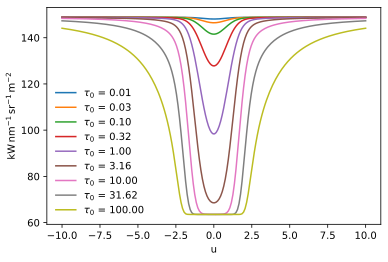

In [7]:
temp_surface = 8770 * units.K
temp_layer = 7000 * units.K
a = 0.1

tau0 = 10 ** np.linspace(-2, 2, 9)

u = np.linspace(-10, 10, 200)

leg = []
plt.figure()
for i in range(len(tau0)): #cycling through and plotting the different line profiles
    plt.plot(u, I(float(tau0[i]), a, lam_0, temp_surface, temp_layer))
    leg.append(r"$\tau_0$ = %.2f"%tau0[i])
plt.xlabel("u")

plt.legend(leg);

Here we see that for very low $\tau_0$ we get almost no emission line, and when increasing we get larger and larger line strength until the line reaches saturation. The low $\tau_0$ profiles are a result of the layer absorbing only some radiation at the wavelength of the spectral line. Then, at larger $\tau_0$, we get a saturation as a result of the layer absorbing all radiation except what itself emits. Thus the radiation at that wavelength is equal to what is produced by the layer's source function. When increasing $\tau_0$ even more, linewings become more prominent. These are a result of the dampening from the Voigt function becoming more important. This broadens the spectral line, resulting in more of the wavelengths being absorbed and scattered. The wings end up at the intensity for the blackbody without the layer, which is also the maximum value for the line profile.

To find which of these models are optically thick or thin, we can calulate the optical depth at $u = 0$

In [8]:
print(" tau_0     tau")
for i in range(len(tau0)):
    print("%6.2f  %6.3f" %(tau0[i], tau0[i] * voigt(a, 0)))

 tau_0     tau
  0.01   0.009
  0.03   0.028
  0.10   0.090
  0.32   0.283
  1.00   0.896
  3.16   2.835
 10.00   8.965
 31.62  28.348
100.00  89.646


From calculating the $\tau_0$ value, we can see that in our model with an $a = 0.1$ we have optical thickness when $\tau_0$ is larger than $1$. This is of course assuming you define optically thick as $\tau > 1$. If you define the criteria to be much larger than one, then we could argue the layer is optically thick first at $\tau_0 > 10$.

We can perform the calculation for a point not at $u = 0$ as well.

In [9]:
tau0_temp = np.linspace(410, 5000, 10)
for i in range(len(tau0_temp)):
    print("%7.2f  %6.2f"%(tau0_temp[i], tau0_temp[i] * voigt(a, 5)))

 410.00    0.99
 920.00    2.21
1430.00    3.44
1940.00    4.67
2450.00    5.90
2960.00    7.12
3470.00    8.35
3980.00    9.58
4490.00   10.81
5000.00   12.03


We choose $u = 5$ and we can see that the $\tau_0$ value needed to obtain an optically thick layer is much higher, reaching values more than two orders of magnitude larger. If we look at the line profile plots we can see that this is a result of the broadning of the spectral line not being large enough for the scattering of radiation to be equally large here as in $u = 0$.

To study the dependence of the spectral line's wavelength, we can perform the calculation done for the differnet $\tau_0$ at infrared and ultraviolet wavelength aswell. First we look at UV.

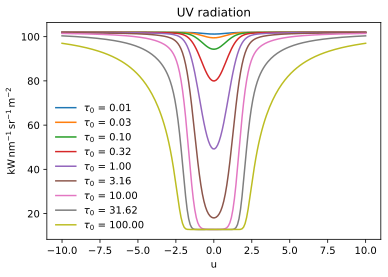

In [10]:
lam_0 = 200 * units.nm

leg = []
plt.figure()
for i in range(len(tau0)):
    plt.plot(u, I(float(tau0[i]), a, lam_0, temp_surface, temp_layer))
    leg.append(r"$\tau_0$ = %.2f"%tau0[i])
plt.xlabel("u")

plt.title("UV radiation")
plt.legend(leg);

Using the same values other than the wavelength, we can see that the overall intensity has been reduced resulting in a downscaling in the intensity for all instanses off the profiles.

For infrared we get:

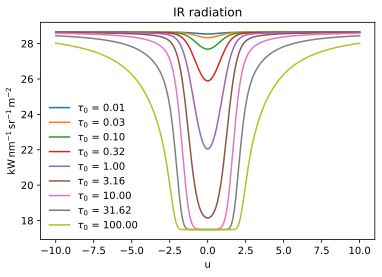

In [11]:
lam_0 = 1000 * units.nm

leg = []
plt.figure()
for i in range(len(tau0)):
    plt.plot(u, I(float(tau0[i]), a, lam_0, temp_surface, temp_layer))
    leg.append(r"$\tau_0$ = %.2f"%tau0[i])
plt.xlabel("u")

plt.title("IR radiation")
plt.legend(leg);

Here we can see that we have also just scaled down the intensity, and even more than for UV-radiation. From the Surface temperature we chose, which is close to the Sun's, we would expect most of the radiation to be in the visible range. Therefore, when looking at wavelengths outside this range we get less intensity. The intensity level reached at $u = 0$, when saturated, is given by the temperature of the layer, which is also quite close to the Sun's surface temperature and therefore will scale with wavelength. We can find these values analytically by computing the blackbody radiation for the two temperatures at the wavelengths equal to the spectral line at the surface temperature and layer temperature we have used.

In [12]:
print("I_cont(IR) =", BlackBody(temp_surface, scale = 1 * units.Unit(i_units))(1000 * units.nm))
print("I_saturated(IR) =", BlackBody(temp_layer, scale = 1 * units.Unit(i_units))(1000 * units.nm))
print("I_cont(UV) =", BlackBody(temp_surface, scale = 1 * units.Unit(i_units))(200 * units.nm))
print("I_saturated(UV) =", BlackBody(temp_layer, scale = 1 * units.Unit(i_units))(200 * units.nm))

I_cont(IR) = 28.643984702166414 kW / (m2 nm sr)
I_saturated(IR) = 17.48980684069755 kW / (m2 nm sr)
I_cont(UV) = 101.96506024269051 kW / (m2 nm sr)
I_saturated(UV) = 12.810252659685686 kW / (m2 nm sr)


We can see that when calculating just the blackbody values for the surface and the layer of the wavelengths, UV and IR, we get approximately the same values as the upper and lower limits of the two plots. Had we performed these caluclations for even more wavelengths, we would expect the results to vary with the Planck function for the surface and layer temperatures.

Until now we have looked at the intensity unnormalised, and it might be hard to get an understanding of how the different line profiles scale with wavelength since the graphs look the same. To help with this, we can plot the intensity normalised by the continuous intensity from the surface, to better see the scaling in difference between the maximum and minimum values and how they vary with the spectral lines' wavelength.

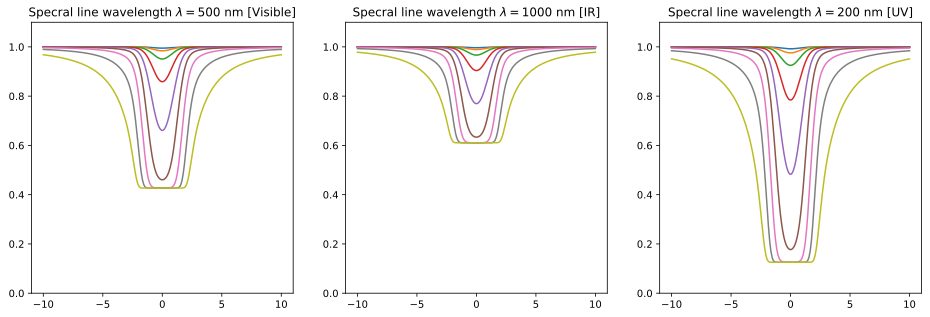

In [13]:
leg = []
fig, ax = plt.subplots(1, 3, figsize = [16, 5])
for i in range(len(tau0)):
    ax[0].plot(u, I(float(tau0[i]), a, 500 * units.nm, temp_surface, temp_layer) / BlackBody(temp_surface, scale = 1 * units.Unit(i_units))(500 * units.nm))
    ax[1].plot(u, I(float(tau0[i]), a, 1000 * units.nm, temp_surface, temp_layer) / BlackBody(temp_surface, scale = 1 * units.Unit(i_units))(1000 * units.nm))
    ax[2].plot(u, I(float(tau0[i]), a, 200 * units.nm, temp_surface, temp_layer) / BlackBody(temp_surface, scale = 1 * units.Unit(i_units))(200 * units.nm))
    leg.append(r"$\tau_0$ = %.2f"%tau0[i])

ax[0].set_ylim(0, 1.1)
ax[1].set_ylim(0, 1.1)
ax[2].set_ylim(0, 1.1)

ax[0].set_title(r"Specral line wavelength $\lambda = 500$ nm [Visible]")
ax[1].set_title(r"Specral line wavelength $\lambda = 1000$ nm [IR]")
ax[2].set_title(r"Specral line wavelength $\lambda = 200$ nm [UV]");

Now we can see that by increasing the wavelength of the spectral line, the relative difference between the layer blackbody intensity and the surface blackbody intensity will decrease. This is a result of the Boltzmann distribution being dependent of the temperature and the wavelength in the
\begin{equation}
\frac{1}{\lambda^5} \frac{1}{e^{hc / k \lambda T} - 1}
\end{equation}
term. Thus for larger wavelength, the temperature dependence will have less effect since the value of the exponential will have less power over the denominator. However, when decreasing the wavelength, the dependence becomes larger, so for UV we can see that the difference is larger.

### Exercise 3

To measure the strength of a spectral line, we use a quantity called the equivalent width. To find the equivalent width we intregrate over the wavelength of the spectral line normalized by the black body spectrum, 
\begin{equation}
    W_\lambda = \int \left( 1 - \frac{I(\lambda)}{I_\text{cont}} \right)\mathrm{d}\lambda\,.
\end{equation}
We can make make use of the earlier function for the Schuster-Schwarzschild model to compute this quantity. The integration can easily be done with $\texttt{numpy}$'s trapezoidal method like so

In [14]:
from numpy import trapz

def W_lambda(tau0, a, wave, T_surface, T_layer):
    I_lambda = I(tau0, a, wave, T_surface, T_layer)
    I_cont = BlackBody(temp_surface, scale=1.*units.Unit(i_units))(wave)
    return trapz((1 - I_lambda/I_cont) , wave)

Choosing some appropriate parameter values for surface temperature, layer temperature, and dampening, we make a plot of the equivalent width against $\tau_0$.

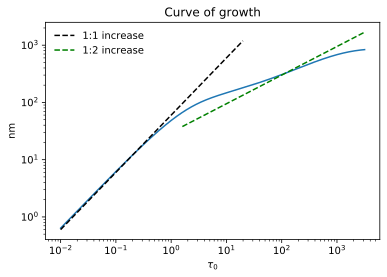

In [15]:
tau0 = 10 ** np.linspace(-2, 3.5, 1000)

temp_surface = 8770 * units.K
temp_layer = 7000 * units.K

end = int(len(tau0)*0.6)
start = int(len(tau0)*0.4)
fig, ax = plt.subplots()
ax.loglog(tau0, W_lambda(tau0, a, wave, temp_surface, temp_layer))
ax.loglog(tau0[:end], 60*tau0[:end], ls = "--", color='k', label="1:1 increase")
ax.loglog(tau0[start:], 30*tau0[start:]**(1/2), ls = "--", color='g', label="1:2 increase")
ax.set_xlabel(r"$\tau_0$")
plt.legend()
ax.set_title("Curve of growth");

In  this figure, we see the curve of growth for the equivalent width of a spectral line. For $\tau \ll 1$, we see a linear increase in the equivalent width. In this region, the layer is not yet saturated and absorbs incoming radiation linearly. After $\tau \sim 1$ the layer starts to become saturated, and the growth slows. The third phase of this figure shows an increase in the growth. This comes from dampening in the Voigt function. For large $\tau_0$, the dampening pulls down the wings of the spectral line and increases its strength. 

For $\tau_\lambda \ll 1$, the Schuster-Schwarzschild model can be approximated
\begin{equation}
    I_\lambda = B_\lambda(T_\text{surface}) e^{-\tau_\lambda} + B_\lambda(T_\text{layer})(1 - e^{-\tau_\lambda}) \approx B_\lambda(T_\text{surface})(1 - \tau_\lambda) + B_\lambda(T_\text{layer})\tau_\lambda\,.
\end{equation}
Thus, we get a linear dependence of $\tau_\lambda$ in the integral of the equivalent width. Since $\tau_\lambda$ is small when $\tau_0$ is small, this approximation should hold for $\tau_0 \ll 1$. Therefore $W_\lambda$ should increase linearly for small $\tau_0$, which implies a 1:1 slope in a logarithmic plot.

Next we will try to change the dampening parameter. Appropriate values usually lie in the interval $a \in [0.01, 0.5]$.

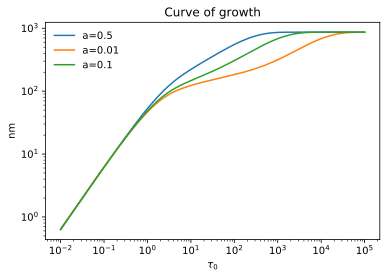

In [16]:
tau0 = 10 ** np.linspace(-2, 5, 1000)

fig, ax = plt.subplots()
ax.loglog(tau0, W_lambda(tau0, 0.5, wave, temp_surface, temp_layer), label="a=0.5")
ax.loglog(tau0, W_lambda(tau0, 0.01, wave, temp_surface, temp_layer), label="a=0.01")
ax.loglog(tau0, W_lambda(tau0, 0.1, wave, temp_surface, temp_layer), label="a=0.1")
ax.set_xlabel(r"$\tau_0$")
plt.legend()
ax.set_title("Curve of growth");

Here we see the curve of growth for three different dampening values $a = 0.01, 0.1, 0.5$. As can be seen from the figure, the dampening parameter detemines the onset of the third part of the slope. A larger $a$ shifts the onset of the third part towards smaller $\tau_0$. For the largest dampening $a = 0.5$, the first part goes directly to the third part. The curve most similar to that of Wright (1948) is the curve with largest separation between the first and third part, i.e. $a = 0.01$. Therefore we estimate the $a$-value for solar iron lines to be of order $10^{-2}$.

To produce emission lines instead of absorption lines, the expectation is that the source function for the layer should be larger than the source function of the solar surface. This is the case when $T_\text{layer} > T_\text{surface}$. We try to increase $T_\text{layer}$ accordingly.

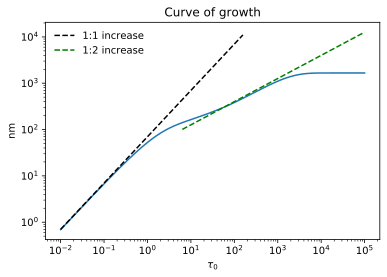

In [17]:
temp_layer = 1.2*temp_surface

end = int(len(tau0)*0.6)
start = int(len(tau0)*0.4)
fig, ax = plt.subplots()
ax.loglog(tau0, np.abs(W_lambda(tau0, a, wave, temp_surface, temp_layer)))
ax.loglog(tau0[:end], 70*tau0[:end], ls = "--", color='k', label="1:1 increase")
ax.loglog(tau0[start:], 40*tau0[start:]**(1/2), ls = "--", color='g', label="1:2 increase")
plt.legend()
ax.set_xlabel(r"$\tau_0$")
ax.set_title("Curve of growth");

In this case, we have to plot the absolute value of the equivalent width. This is bacause emission lines give negative equivalent width. We see that the curve of growth looks similar to the case of a cooler layer, except for a little steeper slope in the third part. This means that the layer emits similarly as it absorbs radiation.